In [78]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
df = pd.read_csv('breast-cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [81]:
def drop_least_correlated(df):

    numeric_df = df.select_dtypes(include='number')

    corr_matrix = numeric_df.corr().abs()

    corr_matrix_lower = corr_matrix.where(~corr_matrix.mask(corr_matrix == 1).isna(), other=None)

    min_corr_value = corr_matrix_lower.min().min()
    least_corr_cols = corr_matrix_lower.stack().idxmin()

    col_to_drop = least_corr_cols[0]

    df_dropped = df.drop(columns=[col_to_drop])

    print(f"Column '{col_to_drop}' has the least correlation with others (correlation: {min_corr_value}) and will be removed.")

    return df_dropped

df_new = drop_least_correlated(df)

print("Updated DataFrame after dropping least correlated column:")
print(df_new)

Column 'id' has the least correlation with others (correlation: 9.570110005915088e-05) and will be removed.
Updated DataFrame after dropping least correlated column:
    diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0           M        17.99         10.38          122.80     1001.0   
1           M        20.57         17.77          132.90     1326.0   
2           M        19.69         21.25          130.00     1203.0   
3           M        11.42         20.38           77.58      386.1   
4           M        20.29         14.34          135.10     1297.0   
..        ...          ...           ...             ...        ...   
564         M        21.56         22.39          142.00     1479.0   
565         M        20.13         28.25          131.20     1261.0   
566         M        16.60         28.08          108.30      858.1   
567         M        20.60         29.33          140.10     1265.0   
568         B         7.76         24.54           47

In [82]:
numeric_columns = df_new.select_dtypes(include=[np.number])

# Initialize a DataFrame to keep track of outlier information
outlier_info = pd.DataFrame(index=numeric_columns.columns)

# Calculate IQR and identify outliers
for col in numeric_columns.columns:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = numeric_columns[col].quantile(0.25)
    Q3 = numeric_columns[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outlier_info.loc[col, 'lower_bound'] = lower_bound
    outlier_info.loc[col, 'upper_bound'] = upper_bound
    outlier_info.loc[col, 'total_outliers'] = ((numeric_columns[col] < lower_bound) | (numeric_columns[col] > upper_bound)).sum()

# Print total number of outliers for each column
print("Total number of outliers in each column:")
print(outlier_info['total_outliers'])

Total number of outliers in each column:
radius_mean                14.0
texture_mean                7.0
perimeter_mean             13.0
area_mean                  25.0
smoothness_mean             6.0
compactness_mean           16.0
concavity_mean             18.0
concave points_mean        10.0
symmetry_mean              15.0
fractal_dimension_mean     15.0
radius_se                  38.0
texture_se                 20.0
perimeter_se               38.0
area_se                    65.0
smoothness_se              30.0
compactness_se             28.0
concavity_se               22.0
concave points_se          19.0
symmetry_se                27.0
fractal_dimension_se       28.0
radius_worst               17.0
texture_worst               5.0
perimeter_worst            15.0
area_worst                 35.0
smoothness_worst            7.0
compactness_worst          16.0
concavity_worst            12.0
concave points_worst        0.0
symmetry_worst             23.0
fractal_dimension_worst    24.0

In [83]:
df_cleaned_no_outliers = df_new[~((numeric_columns < outlier_info.loc[:, 'lower_bound']) | (numeric_columns > outlier_info.loc[:, 'upper_bound'])).any(axis=1)]

# Recompute outliers in the cleaned DataFrame
numeric_columns_cleaned = df_cleaned_no_outliers.select_dtypes(include=[np.number])
outlier_info_cleaned = pd.DataFrame(index=numeric_columns_cleaned.columns)

for col in numeric_columns_cleaned.columns:
    Q1 = numeric_columns_cleaned[col].quantile(0.25)
    Q3 = numeric_columns_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_info_cleaned.loc[col, 'lower_bound'] = lower_bound
    outlier_info_cleaned.loc[col, 'upper_bound'] = upper_bound
    outlier_info_cleaned.loc[col, 'total_outliers'] = ((numeric_columns_cleaned[col] < lower_bound) | (numeric_columns_cleaned[col] > upper_bound)).sum()

# Print total number of outliers for each column after removal
print("\nTotal number of outliers in each column after removal:")
print(outlier_info_cleaned['total_outliers'])


Total number of outliers in each column after removal:
radius_mean                16.0
texture_mean                4.0
perimeter_mean             16.0
area_mean                  24.0
smoothness_mean             0.0
compactness_mean            5.0
concavity_mean             16.0
concave points_mean        10.0
symmetry_mean               1.0
fractal_dimension_mean      3.0
radius_se                  12.0
texture_se                  5.0
perimeter_se               13.0
area_se                    31.0
smoothness_se               7.0
compactness_se             12.0
concavity_se               10.0
concave points_se           2.0
symmetry_se                10.0
fractal_dimension_se       11.0
radius_worst               22.0
texture_worst               1.0
perimeter_worst            17.0
area_worst                 31.0
smoothness_worst            2.0
compactness_worst          11.0
concavity_worst             4.0
concave points_worst        2.0
symmetry_worst              3.0
fractal_dimensio

In [84]:
print("\nMissing Values in the Dataset:")
print(df.isnull().sum())


Missing Values in the Dataset:
id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [85]:
if 'diagnosis' in df.columns:
    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [86]:
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [87]:
# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training the SVM model with a linear kernel
svm_model = SVC(kernel='linear', random_state=42, probability=True)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['linear', 'rbf']  # Kernel types to test
}

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
# Display the best parameters found during GridSearchCV
print("\nBest Parameters from GridSearchCV:")
print(grid_search.best_params_)


Best Parameters from GridSearchCV:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [88]:
# Use the best model found from GridSearchCV for prediction
best_model = grid_search.best_estimator_
# Making predictions on the test set
y_pred = best_model.predict(X_test)
# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 96.49%


In [89]:
# Generating a classification report
classification_report_output = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(classification_report_output)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [90]:
confusion_matrix_output = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(confusion_matrix_output)


Confusion Matrix:
[[71  1]
 [ 3 39]]


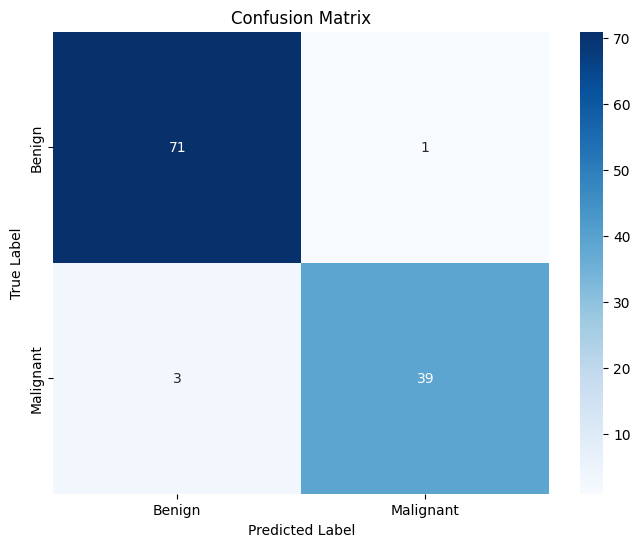

In [91]:
# Visualization of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_output, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


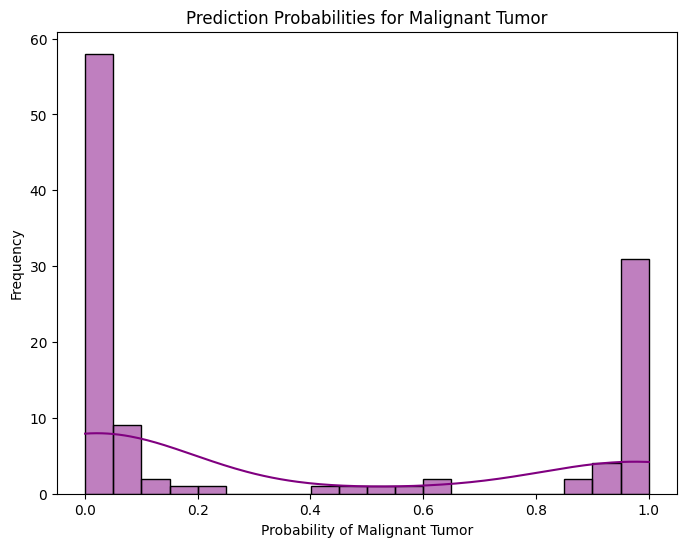

In [92]:
# Visualizing prediction probabilities (for malignant class)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for class '1'

plt.figure(figsize=(8, 6))
sns.histplot(y_prob, kde=True, color='purple', bins=20)
plt.title("Prediction Probabilities for Malignant Tumor")
plt.xlabel("Probability of Malignant Tumor")
plt.ylabel("Frequency")
plt.show()

In [95]:
def predict_unseen_data():
    print("\nPlease enter the features of the tumor to predict its classification:")
    
    # Ensure that the user enters all features in the correct order as per the training data
    unseen_data = []
    for feature in X.columns:
        value = float(input(f"Enter value for {feature}: "))
        unseen_data.append(value)
    
    # Convert to numpy array
    unseen_data = np.array([unseen_data])

    # Standardize the input data using the same scaler fitted on the training data
    unseen_data_scaled = scaler.transform(unseen_data)
    
    # Predict the class (0 for benign, 1 for malignant)
    prediction = best_model.predict(unseen_data_scaled)
    
    # Get the prediction probability for malignant class
    prediction_prob = best_model.predict_proba(unseen_data_scaled)[:, 1]
    
    # Print the result
    if prediction == 1:
        print(f"\nThe tumor is predicted to be Malignant.")
    else:
        print(f"\nThe tumor is predicted to be Benign.")
        
# Call the function to get prediction for unseen data
predict_unseen_data()


Please enter the features of the tumor to predict its classification:


Enter value for id:  2554
Enter value for radius_mean:  13.54
Enter value for texture_mean:  14.36
Enter value for perimeter_mean:  87.96
Enter value for area_mean:  566.3
Enter value for smoothness_mean:  0.0979
Enter value for compactness_mean:  0.08129
Enter value for concavity_mean:  0.06664
Enter value for concave points_mean:  0.047881
Enter value for symmetry_mean:  0.1885
Enter value for fractal_dimension_mean:  0.05766
Enter value for radius_se:  0.2699
Enter value for texture_se:  0.7866
Enter value for perimeter_se:  2.058
Enter value for area_se:  23.56
Enter value for smoothness_se:  0.008462
Enter value for compactness_se:  0.0146
Enter value for concavity_se:  0.02387
Enter value for concave points_se:  0.01318
Enter value for symmetry_se:  0.0198
Enter value for fractal_dimension_se:  0.0023
Enter value for radius_worst:  15.11
Enter value for texture_worst:  19.26
Enter value for perimeter_worst:  99.7
Enter value for area_worst:  711.2
Enter value for smoothness_worst


The tumor is predicted to be Benign.


C:\Users\Saurabh Verma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
